In [1]:
#%autoreload

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import yaml
from tqdm import tqdm, trange
import os
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score, 
    balanced_accuracy_score, 
    confusion_matrix,
    ConfusionMatrixDisplay, 
    accuracy_score,
    classification_report
)
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import yaml
import os

from sklearn.metrics import (
    f1_score, 
    balanced_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns 
from lightgbm import LGBMClassifier
pd.set_option('display.max_columns', None)
from torch import nn, Tensor

from cnn_utils import (
    PTB_Dataset,
    EarlyStopping,
    set_all_seeds,
    train_and_validate,
    test,
)
#os.getcwd()

In [2]:
#%load_ext autoreload

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED = 42

TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 256
TEST_BATCH_SIZE = 256

N_EPOCHS=10

In [39]:
path= r'C:\Users\pauls\Desktop\Studium\Machine Learning for Health Care\Projekt 2\project2_TS_input'
#path = "../../data"
TEST_BATCH_SIZE = 256
SEED = 42

ptb_read_train = pd.read_csv(os.path.join(path, 'ptbdb_train.csv'), header=None)
ptb_read_test = pd.read_csv(os.path.join(path, 'ptbdb_test.csv'), header=None)
X_ptb_train = ptb_read_train.iloc[:, :-1].to_numpy()
X_ptb_test = ptb_read_test.iloc[:, :-1].to_numpy()
y_ptb_train = ptb_read_train.iloc[:, -1].to_numpy()
y_ptb_test = ptb_read_test.iloc[:, -1].to_numpy()

sm = SMOTE(random_state=SEED)
X_ptb_train_resampled, y_ptb_train_resampled = sm.fit_resample(X_ptb_train, y_ptb_train)
print(X_ptb_train_resampled.shape, y_ptb_train_resampled.shape)
print(np.unique(y_ptb_train_resampled, return_counts=True))

# Apply the data loader to the datasets ptb train
ptb_loader_train = DataLoader(
    PTB_Dataset(X_ptb_train_resampled, y_ptb_train_resampled),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    num_workers=0,
)

# Apply the data loader to the datasets ptb test
ptb_loader_test = DataLoader(
    PTB_Dataset(X_ptb_test, y_ptb_test),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    num_workers=0,
)

(16808, 187) (16808,)
(array([0., 1.]), array([8404, 8404], dtype=int64))


## Creating the embeddings:

### Embeddings from the CNN encoder (Q1)

In [40]:
class CNN(nn.Module):
    def __init__(self, classes_num: int, in_channels: int):
        super().__init__()

        self.conv1 = self._create_conv_block(in_channels, 32, 3, 1)
        self.conv2 = self._create_conv_block(32, 64, 3, 1)
        self.conv3 = self._create_conv_block(64, 128, 3, 1)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(output_size = 10)

        self.flatten = nn.Flatten(1)
        self.fc = nn.Sequential(
            nn.Linear(1280, 256),
            nn.Hardswish(),
            nn.Dropout(p=0.2),
            nn.Linear(256, classes_num)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x  

    def _create_conv_block(self, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        return nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=1,
                bias=False
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

class ModifiedCNN(CNN):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.fc[0](x)
        return x

# Replace CNN with the modified version that returns the last conv layer output
model_Q1 = ModifiedCNN(classes_num=5, in_channels=1)

path_Q1 = "../transfer_learning/cnn_best_model_MIT.pth"

model_Q1.load_state_dict(torch.load(path_Q1,map_location=DEVICE))

<All keys matched successfully>

In [41]:
# Obtain representations
# Initialize an empty list to store the embeddings
embeddings_ptb_train = []

# Ensure the model is in evaluation mode
model_Q1.eval()

# No need to track gradients for this
with torch.no_grad():
    # Iterate over the dataset
    for inputs, _ in ptb_loader_train:
        # Move the inputs to the same device as the model
        inputs = inputs.to(DEVICE)

        # Get the embeddings for this batch and append to the list
        embedding = model_Q1(inputs)
        embeddings_ptb_train.append(embedding.cpu().numpy())

# Convert the list of embeddings to a single numpy array
emb_ptb_train_Q1 = np.concatenate(embeddings_ptb_train, axis=0)

In [42]:
embeddings_ptb_test = []

# No need to track gradients for this
with torch.no_grad():
    # Iterate over the dataset
    for inputs, _ in ptb_loader_test:
        # Move the inputs to the same device as the model
        inputs = inputs.to(DEVICE)

        # Get the embeddings for this batch and append to the list
        embedding = model_Q1(inputs)
        embeddings_ptb_test.append(embedding.cpu().numpy())

# Convert the list of embeddings to a single numpy array
emb_ptb_test_Q1 = np.concatenate(embeddings_ptb_test, axis=0)

In [43]:
def stand(df):
    df_new = (df-df.mean())/df.std()
    return pd.DataFrame(df_new)

emb_ptb_train_Q1 = stand(emb_ptb_train_Q1)
emb_ptb_test_Q1 = stand(emb_ptb_test_Q1)

In [47]:
print(emb_ptb_train_Q1.shape)
print(y_ptb_train_resampled.shape)

(16808, 256)
(16808,)


In [48]:
boost_no_feat_eng_Q1 =LGBMClassifier(
    random_state=42,
    verbose=-1,
    n_jobs=-1,
    n_estimators=1000
)
boost_no_feat_eng_Q1.fit(emb_ptb_train_Q1, y_ptb_train_resampled)

y_preds = boost_no_feat_eng_Q1.predict(emb_ptb_test_Q1)

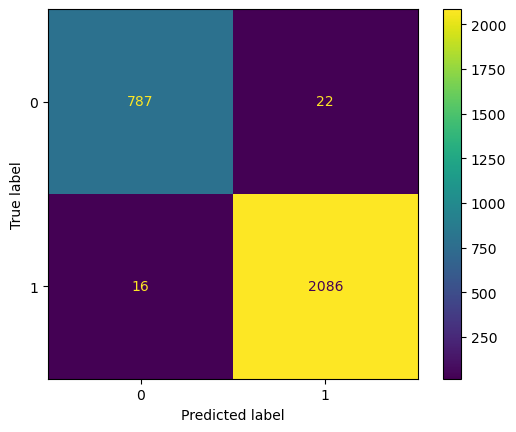

In [49]:
cm = confusion_matrix(y_ptb_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [50]:
# calculate precision and recall:
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Test accuracy: {accuracy_score(y_ptb_test, y_preds):.6f}")
print(f"Test balanced accuracy: {balanced_accuracy_score(y_ptb_test, y_preds):.6f}")
print(f"Test f1 score: {f1_score(y_ptb_test, y_preds):.6f}")
print(f"Test precision: {precision:.6f}")
print(f"Test recall: {recall:.6f}")

Test accuracy: 0.986946
Test balanced accuracy: 0.982597
Test f1 score: 0.990974
Test precision: 0.989564
Test recall: 0.992388


In [51]:
print(classification_report(y_ptb_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       809
         1.0       0.99      0.99      0.99      2102

    accuracy                           0.99      2911
   macro avg       0.98      0.98      0.98      2911
weighted avg       0.99      0.99      0.99      2911



### Embeddings Q2

In [23]:
latent_dim = 256

In [24]:
# We based our CNN on this: https://medium.com/@chen-yu/building-a-customized-residual-cnn-with-pytorch-471810e894ed
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim: int, in_channels: int):
        super().__init__()

        self.conv1 = self._create_conv_block(in_channels, 32, 3, 1)
        self.conv2 = self._create_conv_block(32, 64, 3, 1)
        self.conv3 = self._create_conv_block(64, 128, 3, 1)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(output_size = 10)
        
        
        # Flattening and final linear layer
        self.flatten = nn.Flatten(1)
        self.fc = nn.Linear(1280, latent_dim)

    def forward(self, x: Tensor) -> Tensor:
        x = x.unsqueeze(1) # Add channel dimension
        # now: [batch_size, in_channels, seq_len] i.e. [batch_size, 1, 187]
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.adaptive_pool(x)
        
        x = self.flatten(x)
        x = self.fc(x)
        return x
    
    def _create_conv_block(self, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        return nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=kernel_size, 
                stride=stride, 
                padding=1, 
                bias=False
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )


set_all_seeds(SEED)
encoder=CNNEncoder(latent_dim=latent_dim, in_channels=1).to(DEVICE)

In [26]:
model_Q2 = CNNEncoder(latent_dim=latent_dim, in_channels=1).to(DEVICE)
model_Q2.load_state_dict(torch.load("../weights/encoder_q2.pth", map_location=DEVICE))

<All keys matched successfully>

In [52]:
embeddings_ptb_train = []

# Ensure the model is in evaluation mode
model_Q2.eval()

# No need to track gradients for this
with torch.no_grad():
    # Iterate over the dataset
    for inputs, _ in ptb_loader_train:
        # Move the inputs to the same device as the model
        inputs = inputs.to(DEVICE)

        # Get the embeddings for this batch and append to the list
        embedding = model_Q2(inputs)
        embeddings_ptb_train.append(embedding.cpu().numpy())

# Convert the list of embeddings to a single numpy array
emb_ptb_train_Q2 = np.concatenate(embeddings_ptb_train, axis=0)

In [53]:
embeddings_ptb_test = []

# No need to track gradients for this
with torch.no_grad():
    # Iterate over the dataset
    for inputs, _ in ptb_loader_test:
        # Move the inputs to the same device as the model
        inputs = inputs.to(DEVICE)

        # Get the embeddings for this batch and append to the list
        embedding = model_Q2(inputs)
        embeddings_ptb_test.append(embedding.cpu().numpy())

# Convert the list of embeddings to a single numpy array
emb_ptb_test_Q2 = np.concatenate(embeddings_ptb_test, axis=0)

In [54]:
emb_ptb_train_Q2 = stand(emb_ptb_train_Q2)
emb_ptb_test_Q2 = stand(emb_ptb_test_Q2)

In [55]:
boost_no_feat_eng_Q2 =LGBMClassifier(
    random_state=42,
    verbose=-1,
    n_jobs=-1,
    n_estimators=1000
)
boost_no_feat_eng_Q2.fit(emb_ptb_train_Q2, y_ptb_train_resampled)

y_preds = boost_no_feat_eng_Q2.predict(emb_ptb_test_Q2)

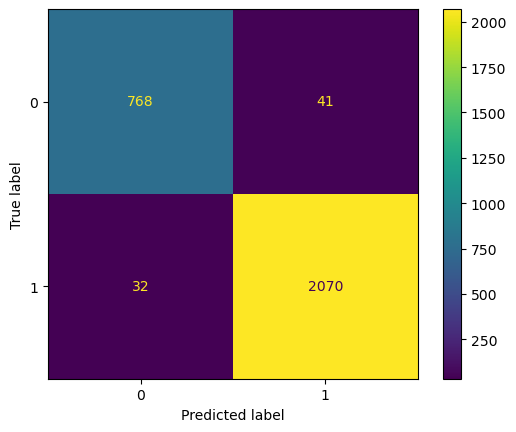

In [56]:
cm = confusion_matrix(y_ptb_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [57]:
# calculate precision and recall:
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Test accuracy: {accuracy_score(y_ptb_test, y_preds):.6f}")
print(f"Test balanced accuracy: {balanced_accuracy_score(y_ptb_test, y_preds):.6f}")
print(f"Test f1 score: {f1_score(y_ptb_test, y_preds):.6f}")
print(f"Test precision: {precision:.6f}")
print(f"Test recall: {recall:.6f}")

Test accuracy: 0.974923
Test balanced accuracy: 0.967048
Test f1 score: 0.982673
Test precision: 0.980578
Test recall: 0.984776


In [58]:
print(classification_report(y_ptb_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95       809
         1.0       0.98      0.98      0.98      2102

    accuracy                           0.97      2911
   macro avg       0.97      0.97      0.97      2911
weighted avg       0.97      0.97      0.97      2911



# MLP output layers

For the MLP layers, we'll first have to introduce a training / validation split. Note that we only apply SMOTE on the training set after the train/ validation split has been done.

In [37]:
X_ptb_train, X_ptb_val, y_ptb_train, y_ptb_val = train_test_split(
    X_ptb_train,
    y_ptb_train,
    test_size=0.1, 
    stratify=y_ptb_train, 
    random_state=42
)

sm = SMOTE(random_state=SEED)
X_ptb_train_resampled, y_ptb_train_resampled = sm.fit_resample(X_ptb_train, y_ptb_train)
print(X_ptb_train_resampled.shape, y_ptb_train_resampled.shape)
print(np.unique(y_ptb_train_resampled, return_counts=True))


(13612, 187) (13612,)
(array([0., 1.]), array([6806, 6806], dtype=int64))


It seems like before the Dataloader got the embeddings as the intput. I will have to think about how to go about this.

In [56]:
ptb_train_loader = DataLoader(
    PTB_Dataset(emb_ptb_train_Q1, y_train_full),
    batch_size=32,
    shuffle=True,
    pin_memory=True,
    num_workers=0,
)
ptb_test_loader = DataLoader(
    PTB_Dataset(emb_ptb_testn_Q1, y_test),
    batch_size=32,
    shuffle=False,
    pin_memory=True,
    num_workers=0,
)

mitbih_train_loader_augmented = DataLoader(
    MITBIH_Augment_Dataset(mitbih_X_train),
    batch_size=config["dataloader"]["augmented_train_batch_size"],
    shuffle=True,
    pin_memory=True,
    num_workers=0,
)

mitbih_val_loader_augmented = DataLoader(
    MITBIH_Augment_Dataset(mitbih_X_val),
    batch_size=config["dataloader"]["augmented_val_batch_size"],
    shuffle=False,
    pin_memory=True,
    num_workers=0,
)

NameError: name 'PTB_Dataset' is not defined

In [55]:
class MLP(nn.Module):
    def __init__(
        self,
        in_size: int,
        out_size: int = 2,
        hidden_profile: list[int] = [1024],
        dropout: float = 0.0,
    ):
        super(MLP, self).__init__()

        self.layers = []
        # add first hidden layer
        self.layers.append(nn.Linear(in_size, hidden_profile[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))

        # loop through hidden profile and add hidden layers
        for hidden_in_size, hidden_out_size in zip(
            hidden_profile[:-1], hidden_profile[1:]
        ):            
            self.layers.append(nn.Linear(hidden_in_size, hidden_out_size))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))

        # add output layer
        self.layers.append(nn.Linear(hidden_profile[-1], out_size))

        self.nn = nn.Sequential(*self.layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.nn(x)
        return x  # Squeeze the output here to ensure correct shape for BCEWithLogitsLoss
    

model = MLP(
    in_size=256,
    out_size=2,
    hidden_profile=[512, 256, 128, 64, 32],
    dropout=0.3
).to(DEVICE)


#TODO Check out HODL for step C, i.e. freezing the Encoder part for the first e.g. 20 epochs, only training the output layers and then after some point start training them both together

In [ ]:
train_and_validate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=N_EPOCHS,
    ES=ES,
    scheduler=scheduler,
    summary_writer=writer,
    device=DEVICE,
    use_penalized_BCE=False
)

test_loss, test_f1_score, balanced_accuracy, model_probs, y_true = test(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=DEVICE,
)